# 02 – Concentration Analysis (Single-Name, Sector, Country, Rating)

In this notebook I analyse **concentration risk** in a synthetic wholesale
corporate loan portfolio.

The goal is to answer:

- How concentrated is exposure in a few **corporate groups**?
- Which **sectors**, **countries**, and **rating bands** drive most of the
  outstanding amount?
- Are there any **concentration flags** a credit committee should be aware of?

All figures below are based on the cleaned exposure table created in
`01_portfolio_overview.ipynb`.



In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.float_format", "{:,.2f}".format)

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 10

In [9]:
data_path = "../data/corp_exposure_snapshot.csv"
df = pd.read_csv(data_path, parse_dates=["origination_date", "maturity_date"])

df.head()

,facility_id,obligor_id,obligor_name,group_id,group_name,country,region,sector,product_type,internal_rating,rating_band,currency,limit_amount,outstanding_amount,undrawn_amount,collateral_value,origination_date,maturity_date,interest_rate,is_defaulted
0,1,183,Obligor_0183,8,Group_008,UK,North America,Transport,Derivatives,4,Investment_Grade,USD,"110,000.00","50,186.00","59,814.00","22,768.00",2022-08-05,2023-10-26,0.04,0
1,2,90,Obligor_0090,33,Group_033,CN,LATAM,Retail,Term_Loan,5,Sub_IG,EUR,"750,000.00","561,751.00","188,249.00","623,818.00",2021-03-12,2022-11-28,0.05,0
2,3,117,Obligor_0117,46,Group_046,KZ,LATAM,Manufacturing,Term_Loan,3,Investment_Grade,EUR,"210,000.00","117,823.00","92,177.00","13,373.00",2023-11-04,2026-12-26,0.04,0
3,4,62,Obligor_0062,20,Group_020,JP,APAC,Energy,Term_Loan,3,Investment_Grade,USD,"520,000.00","305,324.00","214,676.00","344,305.00",2020-10-17,2025-02-21,0.04,0
4,5,23,Obligor_0023,73,Group_073,CN,North America,Transport,Guarantee,2,Investment_Grade,USD,"1,890,000.00","1,168,682.00","721,318.00","1,010,757.00",2016-01-28,2019-07-29,0.03,0


In [10]:
df.shape, df.dtypes

((1000, 20),
 facility_id                    int64
 obligor_id                     int64
 obligor_name                  object
 group_id                       int64
 group_name                    object
 country                       object
 region                        object
 sector                        object
 product_type                  object
 internal_rating                int64
 rating_band                   object
 currency                      object
 limit_amount                 float64
 outstanding_amount           float64
 undrawn_amount               float64
 collateral_value             float64
 origination_date      datetime64[ns]
 maturity_date         datetime64[ns]
 interest_rate                float64
 is_defaulted                   int64
 dtype: object)

In [11]:
total_limit = df["limit_amount"].sum()
total_outstanding = df["outstanding_amount"].sum()
total_undrawn = df["undrawn_amount"].sum()
utilization = total_outstanding / total_limit

kpi_table = pd.DataFrame(
    {
        "metric": [
            "Total limit",
            "Total outstanding",
            "Total undrawn",
            "Utilization",
        ],
        "value": [
            total_limit,
            total_outstanding,
            total_undrawn,
            utilization,
        ],
    }
)

kpi_table


,metric,value
0,Total limit,"570,520,000.00"
1,Total outstanding,"339,943,027.00"
2,Total undrawn,"230,576,973.00"
3,Utilization,0.60


## 1. Single-name (corporate group) concentration

In [12]:
group_exposure = (
    df.groupby("group_name", observed=True)["outstanding_amount"]
      .sum()
      .sort_values(ascending=False)
      .reset_index()
)

group_exposure["share_pct"] = (
    group_exposure["outstanding_amount"] / total_outstanding * 100
)

# Top 20 groups – this should match the table you already saw
top20_groups = group_exposure.head(20).copy()
top20_groups


,group_name,outstanding_amount,share_pct
0,Group_033,"17,153,207.00",5.05
1,Group_054,"11,398,552.00",3.35
2,Group_035,"11,182,325.00",3.29
3,Group_002,"11,068,060.00",3.26
4,Group_019,"10,431,091.00",3.07
5,Group_060,"10,227,978.00",3.01
6,Group_032,"9,288,606.00",2.73
7,Group_024,"9,139,663.00",2.69
8,Group_070,"8,880,372.00",2.61
9,Group_048,"8,095,579.00",2.38


In [14]:
# Top-N concentration metrics
top10_share = (
    group_exposure.head(10)["outstanding_amount"].sum()
    / total_outstanding
    * 100
)

top20_share = (
    group_exposure.head(20)["outstanding_amount"].sum()
    / total_outstanding
    * 100
)

max_single = group_exposure.iloc[0]["share_pct"]

print(f"Largest single-name exposure: {max_single:,.2f}% of portfolio")
print(f"Top 10 groups share       : {top10_share:,.1f}% of portfolio")
print(f"Top 20 groups share       : {top20_share:,.1f}% of portfolio")


Largest single-name exposure: 5.05% of portfolio
Top 10 groups share       : 31.4% of portfolio
Top 20 groups share       : 51.1% of portfolio


In [15]:
# HHI by group
shares = group_exposure["outstanding_amount"] / total_outstanding
hhi = (shares ** 2).sum()
effective_names = 1 / hhi

print(f"Herfindahl-Hirschman Index (HHI): {hhi:,.3f}")
print(f"Effective number of independent names: {effective_names:,.0f}")


Herfindahl-Hirschman Index (HHI): 0.020
Effective number of independent names: 51


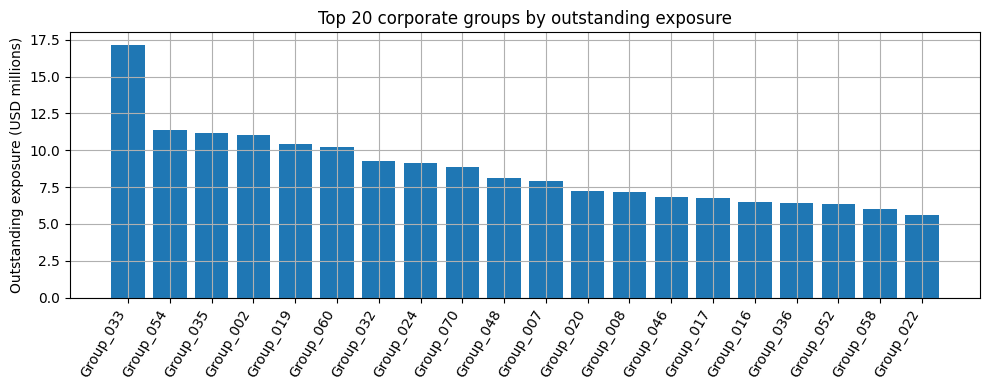

In [16]:
plt.figure(figsize=(10, 4))

subset = top20_groups.copy()
subset["outstanding_mn"] = subset["outstanding_amount"] / 1e6

plt.bar(subset["group_name"], subset["outstanding_mn"])
plt.xticks(rotation=60, ha="right")
plt.ylabel("Outstanding exposure (USD millions)")
plt.title("Top 20 corporate groups by outstanding exposure")

plt.tight_layout()
plt.show()


## 2. Sector concentration

In [17]:
sector_exposure = (
    df.groupby("sector", observed=True)["outstanding_amount"]
      .sum()
      .sort_values(ascending=False)
      .reset_index()
)

sector_exposure["share_pct"] = (
    sector_exposure["outstanding_amount"] / total_outstanding * 100
)
sector_exposure["outstanding_mn"] = (
    sector_exposure["outstanding_amount"] / 1e6
)

sector_exposure


,sector,outstanding_amount,share_pct,outstanding_mn
0,Manufacturing,"69,714,057.00",20.51,69.71
1,TMT,"66,428,053.00",19.54,66.43
2,Retail,"64,069,600.00",18.85,64.07
3,Real_Estate,"41,436,104.00",12.19,41.44
4,Transport,"36,996,240.00",10.88,37.00
5,Utilities,"34,497,513.00",10.15,34.50
6,Energy,"26,801,460.00",7.88,26.80


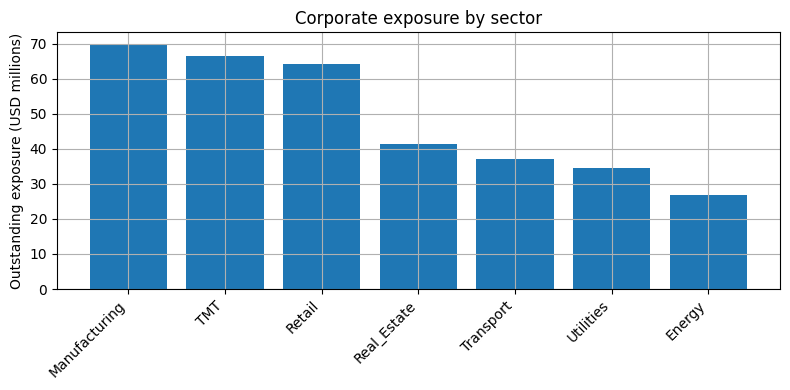

In [19]:
plt.figure()

plt.bar(sector_exposure["sector"], sector_exposure["outstanding_mn"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Outstanding exposure (USD millions)")
plt.title("Corporate exposure by sector")

plt.tight_layout()
plt.show()

## 3. Country concentration

In [20]:
country_exposure = (
    df.groupby("country", observed=True)["outstanding_amount"]
      .sum()
      .sort_values(ascending=False)
      .reset_index()
)

country_exposure["share_pct"] = (
    country_exposure["outstanding_amount"] / total_outstanding * 100
)
country_exposure["outstanding_mn"] = (
    country_exposure["outstanding_amount"] / 1e6
)

country_exposure


,country,outstanding_amount,share_pct,outstanding_mn
0,JP,"74,718,726.00",21.98,74.72
1,CN,"50,027,304.00",14.72,50.03
2,BR,"30,467,285.00",8.96,30.47
3,IT,"29,648,403.00",8.72,29.65
4,US,"28,119,640.00",8.27,28.12
5,DE,"26,634,773.00",7.84,26.63
6,MX,"26,463,980.00",7.78,26.46
7,FR,"25,759,282.00",7.58,25.76
8,UK,"23,310,734.00",6.86,23.31
9,KZ,"15,681,188.00",4.61,15.68


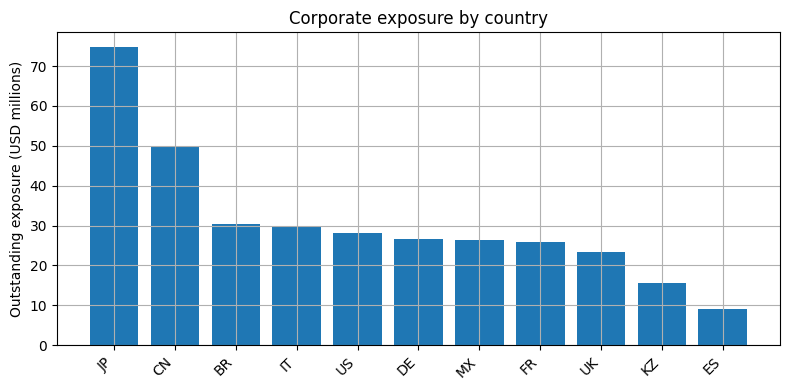

In [21]:
plt.figure()

plt.bar(country_exposure["country"], country_exposure["outstanding_mn"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Outstanding exposure (USD millions)")
plt.title("Corporate exposure by country")

plt.tight_layout()
plt.show()


## 4. Rating-band concentration


In [22]:
rating_exposure = (
    df.groupby("rating_band", observed=True)["outstanding_amount"]
      .sum()
      .sort_values(ascending=False)
      .reset_index()
)

rating_exposure["share_pct"] = (
    rating_exposure["outstanding_amount"] / total_outstanding * 100
)
rating_exposure["outstanding_mn"] = (
    rating_exposure["outstanding_amount"] / 1e6
)

rating_exposure


,rating_band,outstanding_amount,share_pct,outstanding_mn
0,Investment_Grade,"214,560,148.00",63.12,214.56
1,Sub_IG,"88,513,853.00",26.04,88.51
2,Watchlist,"36,869,026.00",10.85,36.87


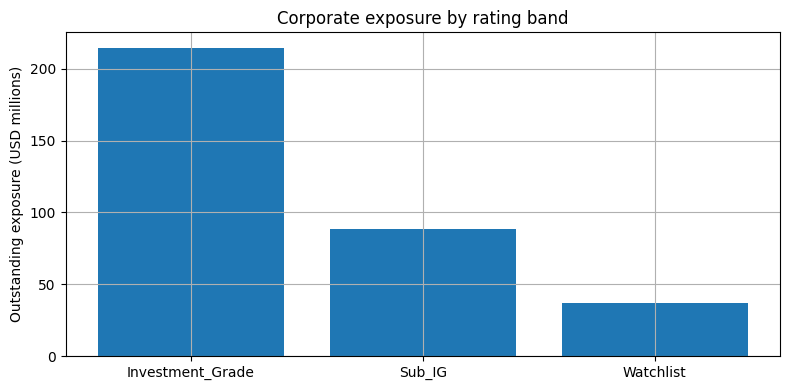

In [23]:
plt.figure()

plt.bar(rating_exposure["rating_band"], rating_exposure["outstanding_mn"])
plt.xticks(rotation=0)
plt.ylabel("Outstanding exposure (USD millions)")
plt.title("Corporate exposure by rating band")

plt.tight_layout()
plt.show()


## 5. Concentration – key findings

**Portfolio snapshot**

- Total committed limit ≈ **570.5M**.
- Total outstanding ≈ **339.9M**, undrawn ≈ **230.6M**.
- Overall utilisation is about **60%**.

**Single-name concentration**

- The largest individual group (`Group_033`) is just above **5%** of total
  outstanding.
- The **top 10 groups** account for roughly **31%** of the portfolio;
  the **top 20** for about **51%**.
- This is a **moderate but visible single-name concentration**: risk is spread
  across many groups, but a relatively small set of large corporates drives half
  of total exposure.

**Sector concentration**

- Exposure is dominated by three sectors:
  - **Manufacturing ~20%**
  - **TMT ~19–20%**
  - **Retail ~19%**
- Together they represent close to **60% of outstanding exposure**, with the
  remaining **40%** split across Real Estate, Transport, Utilities and Energy.
- From a risk-policy perspective, this is typical for a corporate book focused
  on large industrial and TMT clients, but it does mean **cyclical sectors**
  drive the P&L.

**Country concentration**

- The largest country exposures are:
  - **Japan ~22%**, **China ~15%**, **Brazil ~9%**
  - Followed by Italy, US, Germany, Mexico, France and the UK (each ~7–9%).
- No single country exceeds **25%** of the book, but there is a clear **Asia
  tilt** (Japan + China together ~37% of exposure).

**Rating-band mix**

- Around **63%** of exposure is to **Investment-Grade** names,
  **26%** is **Sub-IG**, and roughly **11%** is on the **Watchlist**.
- This is consistent with a **wholesale corporate portfolio with a meaningful
  non-IG and watchlist tail** that needs active monitoring.

**How this would be used in practice**

- Credit risk and portfolio management teams can use these views to:
  - Set **single-name and sector limits** (e.g. max 5% per group, max 25% per
    sector).
  - Track **country and rating-band concentration** against risk appetite.
  - Prioritise **stress-testing** for the sectors and geographies that dominate
    exposure.

This notebook, together with the portfolio overview, provides a clear picture
of **where risk is concentrated** before moving on to migration / PD or stress
testing analysis in later notebooks.
